<a href="https://colab.research.google.com/github/nomotoT/Python_Lesson/blob/master/%E3%83%A1%E3%83%87%E3%82%A3%E3%82%AB%E3%83%ABAI%EF%BC%95%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. 実践編: MRI画像のセグメンテーション


In [3]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==2.4.1
astor==0.7.1
astropy==3.0.5
atari-py==0.1.7
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.6
autograd==1.2
Babel==2.6.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
bokeh==1.0.4
boto==2.49.0
boto3==1.9.123
botocore==1.12.123
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.0
certifi==2019.3.9
cffi==1.12.2
chainer==5.0.0
chainercv==0.12.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cupy-cuda100==5.2.0
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.6
cytoolz==0.9.0.1
daft==0.0.4
dask==0.20.2
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
distributed==1.25.3
Django==2.1.7
dlib==19.16.0
dm-sonnet==1.23
docopt==0.6.2
docutils==0.14

In [0]:
!curl https://colab.chainer.org/install | sh -  # ChainerとCuPyのインストール
!pip install chainercv matplotlib               # ChainerCVとmatplotlibのインストール

In [0]:
import chainer
import cupy
import chainercv
import matplotlib

chainer.print_runtime_info()
print('ChainerCV:', chainercv.__version__)
print('matplotlib:', matplotlib.__version__)

In [0]:
!if [ ! -d train ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/train.zip && unzip train.zip && rm -rf train.zip; fi
!if [ ! -d val ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/val.zip && unzip val.zip && rm -rf val.zip; fi

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# PILライブラリで画像を読み込む
img = np.asarray(Image.open('train/image/000.png'))
label = np.asarray(Image.open('train/label/000.png'))

# matplotlibライブラリを使って2つの画像を並べて表示
fig, axes = plt.subplots(1, 2)
axes[0].set_axis_off()
axes[0].imshow(img, cmap='gray')
axes[1].set_axis_off()
axes[1].imshow(label, cmap='gray')
plt.show()

In [0]:
import glob
from chainer import datasets

def create_dataset(img_filenames, label_filenames):
    img = datasets.ImageDataset(img_filenames)
    img = datasets.TransformDataset(img, lambda x: x / 255.)  # 0-1に正規化
    label = datasets.ImageDataset(label_filenames, dtype=np.int32)
    dataset = datasets.TupleDataset(img, label)
    return dataset

In [0]:
def create_datasets():
    # Python標準のglobを使ってMRI画像ファイル名/ラベル画像ファイル名の一覧を取得
    train_img_filenames = sorted(glob.glob('train/image/*.png'))
    train_label_filenames = sorted(glob.glob('train/label/*.png'))

    # リストを渡して，データセットオブジェクト train を作成
    train = create_dataset(train_img_filenames, train_label_filenames)

    # 同様のことをvalidationデータに対しても行う
    val_img_filenames = sorted(glob.glob('val/image/*.png'))
    val_label_filenames = sorted(glob.glob('val/label/*.png'))
    val = create_dataset(val_img_filenames, val_label_filenames)

    return train, val

In [10]:
train, val = create_datasets()

print('Dataset size:\n\ttrain:\t{}\n\tvalid:\t{}'.format(len(train), len(val)))

Dataset size:
	train:	234
	valid:	26


In [0]:
#5.4.2 モデルの定義
import chainer
import chainer.functions as F
import chainer.links as L

class MultiLayerPerceptron(chainer.Chain):

    def __init__(self, out_h, out_w):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(100, 100)
            self.l3 = L.Linear(100, out_h * out_w)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        n = x.shape[0]

        return h.reshape((n, 1, self.out_h, self.out_w))

In [0]:
#5.4.3. Trainerの定義

from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions

def create_trainer(batchsize, train, val, stop, device=-1):
    # 先程定義したモデルを使用
    model = MultiLayerPerceptron(out_h=256, out_w=256)

    # ピクセルごとの二値分類なので，目的関数にSigmoid cross entropyを，
    # 精度をはかる関数としてBinary accuracyを指定しています
    train_model = L.Classifier(
        model, lossfun=F.sigmoid_cross_entropy, accfun=F.binary_accuracy)

    # 最適化手法にAdamを使います
    optimizer = optimizers.Adam()
    optimizer.setup(train_model)

    # データセットから，指定したバッチサイズ数のデータ点をまとめて取り出して返すイテレータを定義します
    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    # イテレータからデータを引き出し，モデルに渡して，目的関数の値を計算し，backwardしてパラメータを更新，
    # までの一連の処理を行う updater を定義します
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # 様々な付加機能をExtensionとして与えられるTrainerを使います
    trainer = training.trainer.Trainer(updater, stop)

    logging_attributes = [
        'epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy']
    trainer.extend(extensions.LogReport(logging_attributes))
    trainer.extend(extensions.PrintReport(logging_attributes))
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], 'epoch', file_name='accuracy.png'))
    trainer.extend(extensions.Evaluator(val_iter, optimizer.target, device=device), name='val')

    return trainer




In [13]:
#5.4.4. 学習
%%time
trainer = create_trainer(64, train, val, (20, 'epoch'), device=0)
trainer.run()




epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy
1           1.0686      0.512761       0.908777       0.536217           
2           0.772476    0.550955       0.709877       0.577788           
3           0.691255    0.589074       0.659707       0.608414           
4           0.650018    0.623124       0.629166       0.647074           
5           0.611786    0.667053       0.573767       0.70192            
6           0.55581     0.716518       0.513942       0.746447           
7           0.479803    0.770573       0.417202       0.810733           
8           0.377864    0.833751       0.309888       0.869389           
9           0.285714    0.882561       0.233917       0.90713            
10          0.202272    0.921961       0.150058       0.944175           
11          0.12569     0.954799       0.0930156      0.967691           
12          0.0854909   0.970989       0.0666308      0.97727            
13          0.058927    0.980028       0

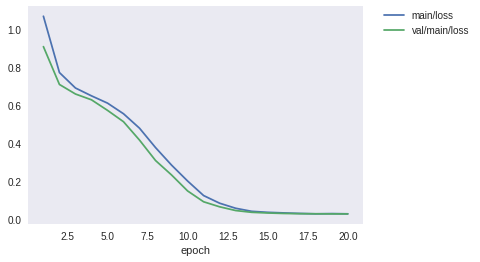

In [14]:
from IPython.display import Image
Image('result/loss.png')

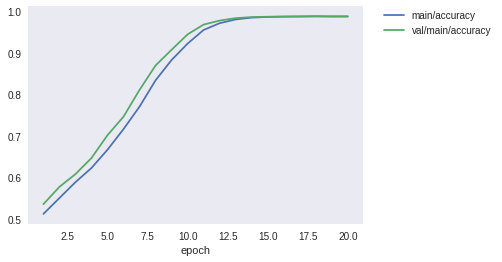

In [15]:
Image('result/accuracy.png')

In [16]:
#5.4.5. 評価
from chainer import cuda
from chainercv import evaluations

def evaluate(trainer, val, device=-1):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    # validationデータ全部に対して予測を行う
    preds = []
    for img, label in val:
        img = cuda.to_gpu(img[np.newaxis], device)
        pred = model(img)
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        preds.append((pred, label[0]))
    pred_labels, gt_labels = zip(*preds)

    # 評価をして結果を表示
    evals = evaluations.eval_semantic_segmentation(pred_labels, gt_labels)
    print('Pixel Accuracy:', evals['pixel_accuracy'])
    print('mIoU:', evals['miou'])

evaluate(trainer, val, device=0)

Pixel Accuracy: 0.9873281625600961
mIoU: 0.6881921231078217


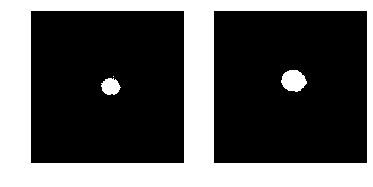

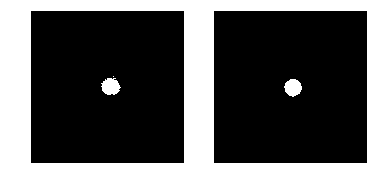

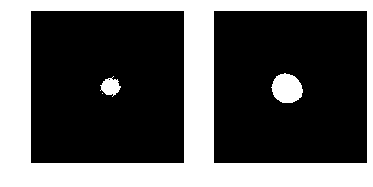

In [17]:
def show_predicts(trainer, val, device=-1, n_sample=3):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    for i in range(n_sample):
        img, label = val[i]
        img = cuda.to_gpu(img, device)
        pred = model(img[np.newaxis])
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        fig, axes = plt.subplots(1, 2)

        axes[0].set_axis_off()
        axes[0].imshow(pred, cmap='gray')

        axes[1].set_axis_off()
        axes[1].imshow(label[0], cmap='gray')

        plt.show()

show_predicts(trainer, val, device=0)

In [19]:
#5.5.3. 全畳込みネットワーク

from chainer import reporter
from chainer import cuda
from chainercv import evaluations

FIXME_1 = 64
FIXME_2 = 128
FIXME_3 = 128
FIXME_4 = 128
FIXME_5 = 128


class FullyConvolutionalNetwork(chainer.Chain):

    def __init__(self, out_h, out_w, n_class=1):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Convolution2D(out_ch, ksize, stride, pad)
            # とかくこともできます．
            self.conv1 = L.Convolution2D(None, FIXME_1, ksize=5, stride=2, pad=2)
            self.conv2 = L.Convolution2D(None, FIXME_2, ksize=5, stride=2, pad=2)
            self.conv3 = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(None, FIXME_4, ksize=3, stride=1, pad=1)
            self.conv5 = L.Convolution2D(None, FIXME_5, ksize=1, stride=1, pad=0)
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Deconvolution2D(out_ch, ksize, stride, pad)
            # と書くこともできます．
            self.deconv6 = L.Deconvolution2D(None, n_class, ksize=32, stride=16, pad=8)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = self.conv5(h)
        h = self.deconv6(h)

        return h.reshape(x.shape[0], 1, h.shape[2], h.shape[3])

print(FullyConvolutionalNetwork(256, 256)(np.zeros((1, 1, 256, 256), dtype=np.float32)).shape[2:])


(256, 256)


In [0]:
# 5.5.4. Classifierクラスの改良
class PixelwiseSigmoidClassifier(chainer.Chain):

    def __init__(self, predictor):
        super().__init__()
        with self.init_scope():
            # 学習対象のモデルをpredictorとして保持しておく
            self.predictor = predictor

    def __call__(self, x, t):
        # 学習対象のモデルでまず推論を行う
        y = self.predictor(x)

        # 2クラス分類の誤差を計算
        loss = F.sigmoid_cross_entropy(y, t)

        # 予測結果（0~1の連続値を持つグレースケール画像）を二値化し，
        # ChainerCVのeval_semantic_segmentation関数に正解ラベルと
        # 共に渡して各種スコアを計算
        y, t = cuda.to_cpu(F.sigmoid(y).data), cuda.to_cpu(t)
        y = np.asarray(y > 0.5, dtype=np.int32)
        y, t = y[:, 0, ...], t[:, 0, ...]
        evals = evaluations.eval_semantic_segmentation(y, t)

        # 学習中のログに出力
        reporter.report({'loss': loss,
                         'miou': evals['miou'],
                         'pa': evals['pixel_accuracy']}, self)
        return loss

In [0]:
# 5.5.5. 新しいモデルを使った学習

def create_trainer(batchsize, train, val, stop, device=-1, log_trigger=(1, 'epoch')):
    model = FullyConvolutionalNetwork(out_h=256, out_w=256)
    train_model = PixelwiseSigmoidClassifier(model)

    optimizer = optimizers.Adam(eps=1e-05)
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, stop, out='result_fcn')

    logging_attributes = [
        'epoch', 'main/loss', 'main/miou', 'main/pa',
        'val/main/loss', 'val/main/miou', 'val/main/pa']
    trainer.extend(extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/miou', 'val/main/miou'], 'epoch', file_name='miou.png'))
    trainer.extend(extensions.PlotReport(['main/pa', 'val/main/pa'], 'epoch', file_name='pa.png'))
    trainer.extend(extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer

In [22]:
%%time
trainer = create_trainer(128, train, val, (200, 'epoch'), device=0, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          0.210353    0.492071    0.984142    0.201221       0.491136       0.982272     
20          0.0700971   0.490788    0.981576    0.0727054      0.491152       0.982304     
30          0.0464805   0.492328    0.983783    0.0526816      0.492837       0.982303     
40          0.0398336   0.559407    0.984702    0.0470694      0.586247       0.984204     
50          0.0331368   0.690149    0.988401    0.0370608      0.622374       0.986024     
60          0.0244433   0.715562    0.990303    0.0303805      0.743041       0.988312     
70          0.0232846   0.734349    0.990582    0.0265951      0.78506        0.989898     
80          0.0165652   0.841488    0.993715    0.0183224      0.795902       0.992404     
90          0.0146398   0.823306    0.994027    0.0156916      0.826934       0.993473     
100         0.0107299   0.87381     0.995844    0.0145188      0.852777       0.99

Loss


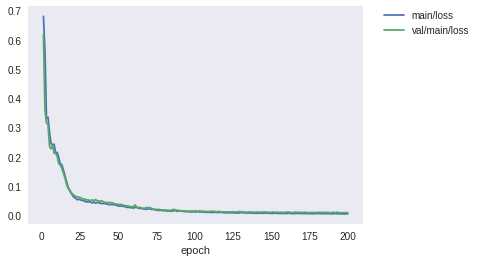

In [23]:
#5.5.6. 学習結果を見てみよう
from IPython.display import Image
print('Loss')
Image('result_fcn/loss.png')

mean IoU


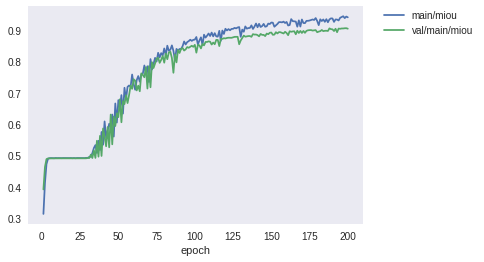

In [24]:
print('mean IoU')
Image('result_fcn/miou.png')

Pixel Accuracy


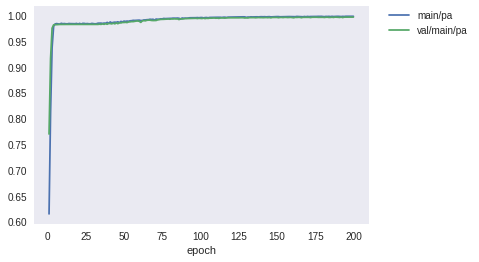

In [25]:
print('Pixel Accuracy')
Image('result_fcn/pa.png')

Pixel Accuracy: 0.9964394202599158
mIoU: 0.9043045208971667


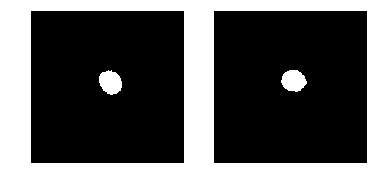

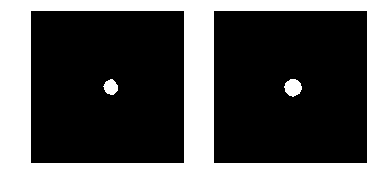

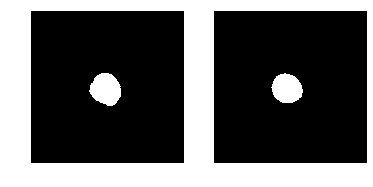

In [26]:
evaluate(trainer, val, device=0)
show_predicts(trainer, val, device=0, )

Pixel Accuracy: 0.9964394202599158
mIoU: 0.9043045208971667


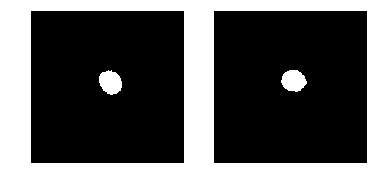

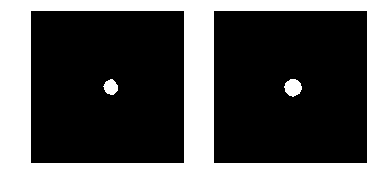

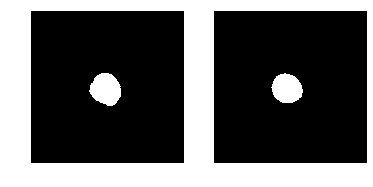

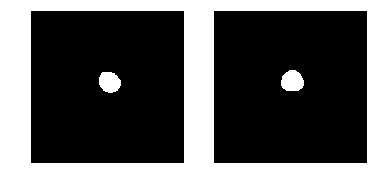

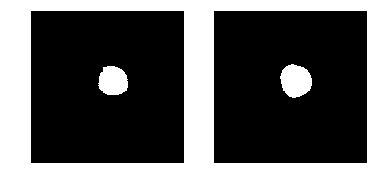

In [30]:
evaluate(trainer, val, device=0)
show_predicts(trainer, val, device=0, n_sample=5)

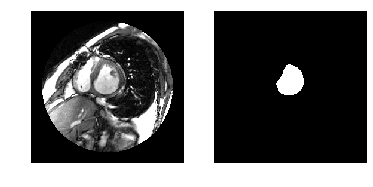

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# PILライブラリで画像を読み込む
img = np.asarray(Image.open('train/image/002.png'))
label = np.asarray(Image.open('train/label/002.png'))

# matplotlibライブラリを使って2つの画像を並べて表示
fig, axes = plt.subplots(1, 2)
axes[0].set_axis_off()
axes[0].imshow(img, cmap='gray')
axes[1].set_axis_off()
axes[1].imshow(label, cmap='gray')
plt.show()

In [0]:
def show_predicts2(trainer, val, device=-1, n_sample=3):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    for i in range(n_sample):
      
      # PILライブラリで画像を読み込む
      
        s_img = 'train/image/00' + str(i) + '.png'
        s_label =  'train/label/00' + str(i) + '.png'
        
        img2 = np.asarray(Image.open(s_img))
        label2 = np.asarray(Image.open(s_label))
                            
        img, label = val[i]
        img = cuda.to_gpu(img, device)
        pred = model(img[np.newaxis])
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        fig, axes = plt.subplots(1, 4)

        axes[0].set_axis_off()  #予測ラベル
        axes[0].imshow(pred, cmap='gray')

        axes[1].set_axis_off()  #正解ラベル
        axes[1].imshow(label[0], cmap='gray')
        
        axes[2].set_axis_off()  #MRI画像
        axes[2].imshow(img2, cmap='gray')
        
        axes[3].set_axis_off() #専門家がマスクした画像
        axes[3].imshow(label2, cmap='gray')

        plt.show()


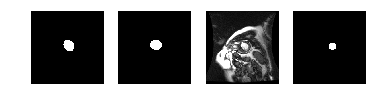

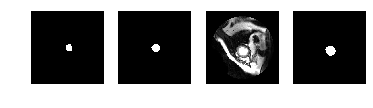

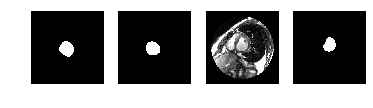

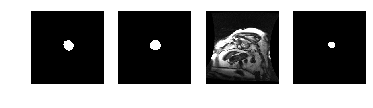

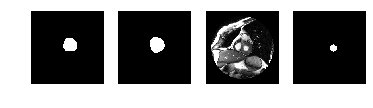

In [53]:
show_predicts2(trainer, val, device=0, n_sample=5)